# Project: SQLite Advanced JOINS and Subqueries (Business Questions)

<br>

## Questions to address:
- Perform advanced JOINS and subqueries to answer question on stats of music purchases
- Find which genres sell the most tracks in the USA
- Analyze the sells of each sales rep employee
- Analyze sales data for customers in different countries
- Compute percentage of album purchases

<br>

## Tools:
- INNER JOIN
- subqueries
- CREATE VIEW
- CASE WHEN
- EXCEPT
- plotting

<br>

### load defaults

In [4]:
import sqlite3
import pandas as pd
import re
import numpy as np
import requests 
import os
import shutil

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

<br>

### Create some functions to help with queries

In [5]:
def run_query(q):
    with sqlite3.connect('./data/chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('./data/chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    query = """
            SELECT name,
                   type
              FROM sqlite_master
             WHERE type IN ("table","view");"""
    return run_query(query)

<br>

## Dataset: chinook music database

We will modify the original database so the first thing to do is to copy the original into a new file

In [19]:
try:
    os.remove("./data/chinook.db")
    print("file removed")
except:
    print("file not present")
    
shutil.copy("./data/chinook_original.db", "./data/chinook.db")
print("copy created")

file removed
copy created


In [11]:
df = show_tables()
display(df)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


<br>

### Q1: Which genres sell the most tracks in the USA

Query to return each genre with the number of tracks sold (absolute numbers and percentages)

- select all invoices lines where id = invoice.id and invoice.country = USA
- for all previously select invoice lines :
    - select track name and genre from track and genre tables using invoice_lines.track_id, track.genre_id
- group by genre and count

,tracks_sold
genre,
Rock,561
Alternative & Punk,130
Metal,124


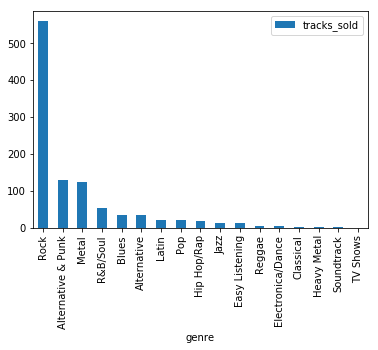

In [20]:
q = """
WITH USA_invoice_lines AS
(
    SELECT * from invoice_line il
INNER JOIN invoice i on i.invoice_id = il.invoice_id
     where i.billing_country = 'USA'
),

track_genre_quantity AS
(
    SELECT il.*, 
           t.name as track_name,
           g.name as genre
           
      from USA_invoice_lines il
INNER JOIN track t on t.track_id = il.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
)

  select genre, count(*) as tracks_sold
    from track_genre_quantity
group by 1
order by 2 desc
"""
df = run_query(q)
df.set_index('genre', inplace=True)
display(df[:3])

df.plot(kind='bar');

Best sells: Rock, then Alternative & Punk, then Blues, then POP, then Hip-Hop

<br>

### Q2: Analyze the sells of each sales rep employee

- select costumer, and costumer representative, then total_number of purchases (from invoice line) and value (from invoice) by grouping on costumers 
- then select representative name, total sales, etc by joining on employee_id

,name,total,birthdate,hire_date,country
0,Jane Peacock,18246.69,1973-08-29 00:00:00,2017-04-01 00:00:00,Canada
1,Margaret Park,15923.16,1947-09-19 00:00:00,2017-05-03 00:00:00,Canada
2,Steve Johnson,13333.32,1965-03-03 00:00:00,2017-10-17 00:00:00,Canada


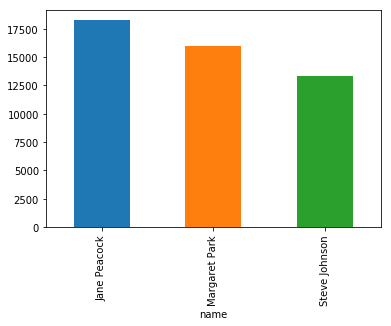

In [21]:
q = """
WITH customer_totals AS
(
select c.customer_id, 
       c.support_rep_id,
       c.first_name || " " || c.last_name as name,
       SUM(il.quantity) as total_number, 
       SUM(i.total) as total
       from customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
group by c.customer_id
)

select e.first_name || " " || e.last_name as name,       
       SUM(ct.total) as total,
       e.birthdate,
       e.hire_date,
       e.country
       

from customer_totals ct
INNER JOIN employee e ON e.employee_id = ct.support_rep_id
group by e.employee_id
order by 2 desc
"""
df = run_query(q)
    
display(df)

df.set_index('name', inplace=True)
df['total'].plot(kind='bar');

### Plot sales versus days working

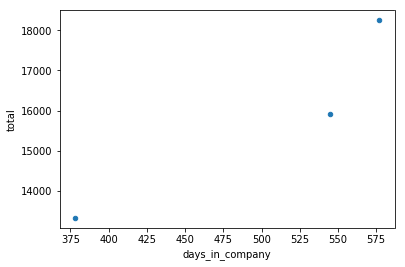

In [22]:
present_time = pd.Timestamp.now()

df['hire_date'] = pd.DatetimeIndex(df['hire_date'])
df['days_in_company'] = (present_time-df['hire_date']).dt.days

df.plot.scatter(x='days_in_company', y='total');

- The total volume of sales seems to just measure the number of days that the sales rep has been working for

<br>

### Q3: Sales data for customers in different countries

<br>

<b> Count number of Costumers per country</b>
- counted number of costumers grouped by country (if only 1 costumer put in 'other' category)
- group again by country to add up nubmer of countries in 'other category' and hence get number of costumers
- select number of costumer per country while putting other at the end of list

In [35]:
q = """
CREATE VIEW IF NOT EXISTS country_counts AS
     select c.customer_id,
            CASE
              WHEN count(*) > 1 THEN country
              ELSE "Other"
            END AS country,
            count(*)  as count           
       from customer c       
   group by c.country
   order by 3 desc """
run_command(q)

q = """
CREATE VIEW IF NOT EXISTS country_counts_with_Other AS
select country,
       CASE
          WHEN count > 1 THEN count
          ELSE SUM(count)          
       END AS count
 
 from country_counts
group by country
order by 2 DESC """
run_command(q)

#just to put Other at the bottom of the list
q = """
CREATE VIEW IF NOT EXISTS final_country_counts AS
   SELECT country,
          count
     from 
         (
           select cc_other.*,
                  CASE 
                     WHEN cc_other.country = "Other" THEN 1
                     ELSE 0
                  END as sorted
             from country_counts_with_Other cc_other
         )
 ORDER BY sorted ASC """ 
run_command(q)
    
q = """ select * from final_country_counts"""
df = run_query(q)    
display(df.iloc[[0,1,2,3,9],:])

,country,count
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
9,Other,15


<br>

<b>Create a new table with costumer_id, original_country and country (other if it was other in previous query)</b>

In [37]:
q = """
CREATE VIEW IF NOT EXISTS country_list_other AS

select c.customer_id, 
       c.country as original_country,
       c.country
  from customer c
 INNER JOIN final_country_counts fcc ON  fcc.country = c.country

UNION ALL

select c.customer_id,
       c.country as original_country,
       CASE
          WHEN 1 THEN "Other"
       END as country         
  from customer c
 where c.country NOT IN (select country from final_country_counts)

"""
run_command(q)

q="select * from country_list_other" 
df = run_query(q)    
display(df.iloc[41:46,:])

,customer_id,original_country,country
41,54,United Kingdom,United Kingdom
42,58,India,India
43,59,India,India
44,4,Norway,Other
45,7,Austria,Other


<br>

<b>Compute total sales per country</b>
- Join country_list_other and invoice on costumer_id
- group by countries
- select number of clients, sum of sales, sum of sales/count(*) as value per order

In [40]:
#Main query
q="""
CREATE VIEW IF NOT EXISTS sales as
     select co.country, 
            fcc.count as N_clients,
            SUM(i.total) as total,
            SUM(i.total)/fcc.count as average_per_client,
            SUM(i.total)/count(*) as average_per_order
       from country_list_other co
 LEFT JOIN invoice i ON i.customer_id = co.customer_id
 LEFT JOIN final_country_counts fcc ON fcc.country = co.country
 group by co.country
 order by 2 DESC"""
run_command(q)

#Put Other in the end
q="""
CREATE VIEW IF NOT EXISTS total_sales as
select country, 
       N_clients,
       total as total_sales,
       average_per_client,
       average_per_order
from
(
    select *,
           CASE
             WHEN s.country = "Other" THEN 1
             ELSE 0
           END AS sort
    from sales s
 )
order by sort 
"""
run_command(q)
    

q="""select * from total_sales"""    
df = run_query(q)    
display(df.iloc[[0,1,2,3,9],:])    

,country,N_clients,total_sales,average_per_client,average_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
9,Other,15,1094.94,72.996000,7.448571


<br>

<b>Plot histograms for 'N_clients', 'total_sales', 'average_per_client' and 'average_per_order' for different countries</b>

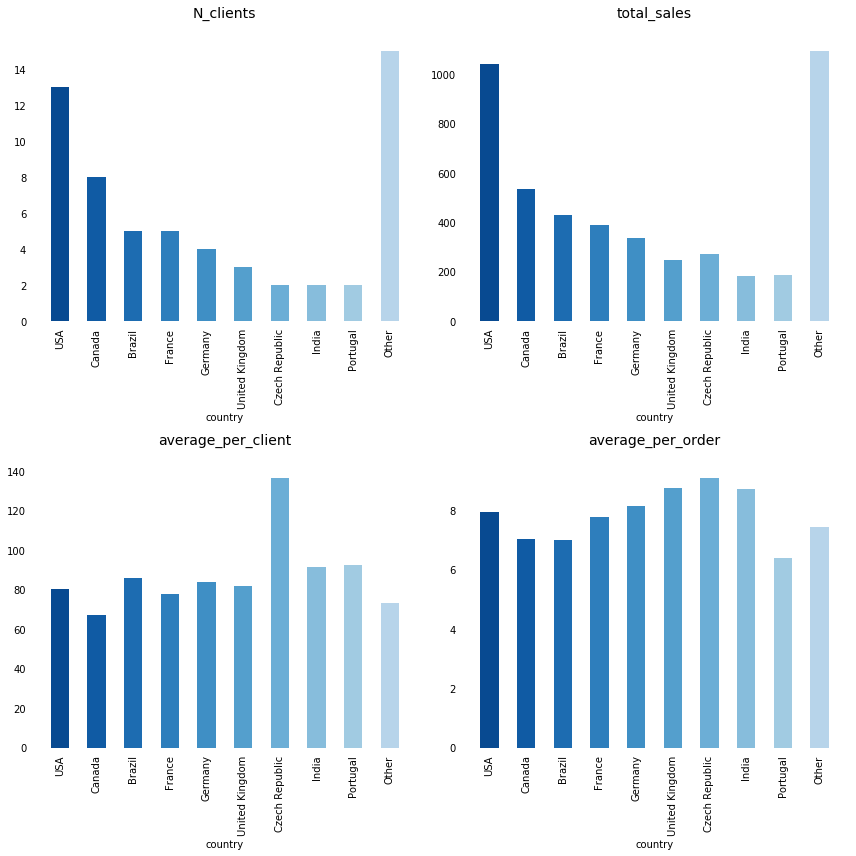

In [44]:
import matplotlib.pyplot as plt
import numpy as np

cats = ['N_clients','total_sales','average_per_client','average_per_order']
fig = plt.figure(figsize=(12,12))

bar_positions = np.arange(0,len(df),1.) + 1.
tick_positions = range(1,len(df)+1)
    
color_map = plt.cm.Blues
bar_colors = [color_map(i) for i in np.linspace(0.9, 0.3, len(df))]
for sp, element in enumerate(cats):
    ax = fig.add_subplot(2,2,sp+1)
    bar_heights = df[element].values
 
    ax.bar(bar_positions,bar_heights,width=0.5,color=bar_colors)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(df['country'], rotation=90)
    ax.set_xlabel('country')
    ax.set_title(element, fontsize=14)
    
    for key,spine in ax.spines.items():
        spine.set_visible(False)
    ax.tick_params(bottom=False, top=False, left=False, right=False)

plt.tight_layout()

<br>

### Q4: Compute percentage of album purchases

- select invoice_id and first album_id by joining invoice_line and track and grouping by invoice_id
- then check the if there is any difference between selecting all track from invoice_line and track (if not, album purchase)

In [50]:
q= """
WITH invoice_first_album as
(
    select il.invoice_id, 
           t.album_id
      from invoice_line il
      INNER JOIN track t ON t.track_id = il.track_id
  group by il.invoice_id
)

select AP as album_purchase,
       Count(*) as Invoice_Number,
       CAST(Count(*) AS float)/(select count(*) from invoice_first_album) as percentage
  from 
    (
       select *, 
              CASE WHEN
                (
                  select t.track_id 
                    from track t
                  where t.album_id = ia.album_id                  
                  EXCEPT
                  select il.track_id 
                    from invoice_line il
                  where il.invoice_id = ia.invoice_id 
                ) IS NULL                
                AND
                (
                  select il.track_id 
                    from invoice_line il
                  where il.invoice_id = ia.invoice_id                
                  EXCEPT
                  select t.track_id 
                    from track t
                  where t.album_id = ia.album_id                   
                ) IS NULL
                
                then "yes"
              ELSE "no"
              END as AP       

       from invoice_first_album ia
    )
group by AP
"""
df = run_query(q)    
display(df)

,album_purchase,Invoice_Number,percentage
0,no,500,0.814332
1,yes,114,0.185668
